In [1]:
import os
if not os.path.exists('guided-filter-pytorch'):
    !git clone https://github.com/perrying/guided-filter-pytorch.git

# Thêm đường dẫn vào sys.path
import sys
sys.path.append('/kaggle/working/guided-filter-pytorch')

Cloning into 'guided-filter-pytorch'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 6), reused 20 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 3.80 MiB | 19.88 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights, resnet50, ResNet50_Weights
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Import guided filter từ thư viện đã clone
from guided_filter import GuidedFilter2d

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [4]:
class CrackDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_name = os.path.splitext(img_name)[0] + '.png'
        mask_path = os.path.join(self.mask_dir, mask_name)
        if not os.path.exists(mask_path):
            mask_path = os.path.join(self.mask_dir, img_name)
        
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform: image = self.image_transform(image)
        if self.mask_transform: mask = self.mask_transform(mask)

        return image, (mask > 0.5).float()

In [5]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [6]:
BATCH_SIZE = 8
train_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/train/label', image_transform=image_transform, mask_transform=mask_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataset = CrackDataset('/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/image', '/kaggle/input/udtiri-crack/UDTIRI-Crack/UDTIRI-Crack Detection/val/label', image_transform=image_transform, mask_transform=mask_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print("Dataset and DataLoader are ready.")

Dataset and DataLoader are ready.


In [7]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.float(), reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean() if self.reduction == 'mean' else F_loss.sum()

In [8]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs_flat = inputs.view(-1)
        targets_flat = targets.view(-1)
        intersection = (inputs_flat * targets_flat).sum()
        dice_score = (2. * intersection + self.smooth) / (inputs_flat.sum() + targets_flat.sum() + self.smooth)
        return 1 - dice_score

In [9]:
class DiceFocalLoss(nn.Module):
    def __init__(self, weight_dice=0.5, weight_focal=0.5):
        super(DiceFocalLoss, self).__init__()
        self.dice_loss = DiceLoss()
        self.focal_loss = FocalLoss()
        self.weight_dice = weight_dice
        self.weight_focal = weight_focal
    def forward(self, inputs, targets):
        return self.weight_dice * self.dice_loss(inputs, targets) + self.weight_focal * self.focal_loss(inputs, targets)

In [10]:
class DeepSupervisionBCELoss(nn.Module):
    def __init__(self):
        super(DeepSupervisionBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()

    def forward(self, outputs, targets):
        total_loss = 0
        num_side_outputs = len(outputs) - 1
        
        for i in range(num_side_outputs):
            out = outputs[i]
            target_resized = F.interpolate(targets, size=out.shape[2:], mode='bilinear', align_corners=False)
            total_loss += 0.5 * self.bce_loss(out, target_resized)
        
        final_out = outputs[-1]
        target_resized = F.interpolate(targets, size=final_out.shape[2:], mode='bilinear', align_corners=False)
        total_loss += 1.1 * self.bce_loss(final_out, target_resized)
        
        return total_loss

In [11]:
class DeepSupervisionFocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0):
        super(DeepSupervisionFocalLoss, self).__init__()
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma, reduction='mean')

    def forward(self, outputs, targets):
        total_loss = 0
        num_side_outputs = len(outputs) - 1
        
        for i in range(num_side_outputs):
            out = outputs[i]
            target_resized = F.interpolate(targets, size=out.shape[2:], mode='bilinear', align_corners=False)
            total_loss += 0.5 * self.focal_loss(out, target_resized)
        
        final_out = outputs[-1]
        target_resized = F.interpolate(targets, size=final_out.shape[2:], mode='bilinear', align_corners=False)
        total_loss += 1.1 * self.focal_loss(final_out, target_resized)
        
        return total_loss

In [12]:
class DeepSupervisionDiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DeepSupervisionDiceLoss, self).__init__()
        self.dice_loss = DiceLoss(smooth=smooth)

    def forward(self, outputs, targets):
        total_loss = 0
        num_side_outputs = len(outputs) - 1
        
        for i in range(num_side_outputs):
            out = outputs[i]
            target_resized = F.interpolate(targets, size=out.shape[2:], mode='bilinear', align_corners=False)
            total_loss += 0.5 * self.dice_loss(out, target_resized)
        
        final_out = outputs[-1]
        target_resized = F.interpolate(targets, size=final_out.shape[2:], mode='bilinear', align_corners=False)
        total_loss += 1.1 * self.dice_loss(final_out, target_resized)
        
        return total_loss

In [13]:
class DeepSupervisionDiceFocalLoss(nn.Module):
    def __init__(self):
        super(DeepSupervisionDiceFocalLoss, self).__init__()
        self.dice_focal_loss = DiceFocalLoss()

    def forward(self, outputs, targets):
        total_loss = 0
        num_side_outputs = len(outputs) - 1
        
        for i in range(num_side_outputs):
            out = outputs[i]
            target_resized = F.interpolate(targets, size=out.shape[2:], mode='bilinear', align_corners=False)
            total_loss += 0.5 * self.dice_focal_loss(out, target_resized)
        
        final_out = outputs[-1]
        target_resized = F.interpolate(targets, size=final_out.shape[2:], mode='bilinear', align_corners=False)
        total_loss += 1.1 * self.dice_focal_loss(final_out, target_resized)
        
        return total_loss

In [14]:
class DeepCrack_ResNet50(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(DeepCrack_ResNet50, self).__init__()
        weights = ResNet50_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = resnet50(weights=weights)
        
        return_nodes = {
            'layer1': 's1',
            'layer2': 's2',
            'layer3': 's3',
            'layer4': 's4'
        }
        self.feature_extractor = create_feature_extractor(backbone, return_nodes=return_nodes)
        
        self.side_conv1 = nn.Conv2d(256, num_classes, 1)
        self.side_conv2 = nn.Conv2d(512, num_classes, 1)
        self.side_conv3 = nn.Conv2d(1024, num_classes, 1)
        self.side_conv4 = nn.Conv2d(2048, num_classes, 1)
        
        self.fuse_conv = nn.Conv2d(num_classes * 4, num_classes, 1)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def forward(self, x):
        features = self.feature_extractor(x)
        f1, f2, f3, f4 = features['s1'], features['s2'], features['s3'], features['s4']
        
        s1 = self.side_conv1(f1)
        s2 = self.side_conv2(f2)
        s3 = self.side_conv3(f3)
        s4 = self.side_conv4(f4)
        
        s2_up = F.interpolate(s2, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s3_up = F.interpolate(s3, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s4_up = F.interpolate(s4, size=s1.shape[2:], mode='bilinear', align_corners=False)
        
        side_outputs_resized = [s1, s2_up, s3_up, s4_up]
        fused = self.fuse_conv(torch.cat(side_outputs_resized, dim=1))
        guided_fused = self.guided_filter(fused, s1)
        
        final_outputs = []
        for s in side_outputs_resized:
            final_outputs.append(F.interpolate(s, size=x.shape[2:], mode='bilinear', align_corners=False))
        final_outputs.append(F.interpolate(guided_fused, size=x.shape[2:], mode='bilinear', align_corners=False))

        return final_outputs

In [15]:
class DeepCrack_EfficientNetB0(nn.Module):
    def __init__(self, num_classes=1, pretrained=True):
        super(DeepCrack_EfficientNetB0, self).__init__()
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1 if pretrained else None
        backbone = efficientnet_b0(weights=weights).features
        
        return_nodes = {'1': 's1', '2': 's2', '3': 's3', '5': 's4', '7': 's5'}
        self.feature_extractor = create_feature_extractor(backbone, return_nodes=return_nodes)
        
        self.side_conv1 = nn.Conv2d(16, num_classes, 1)
        self.side_conv2 = nn.Conv2d(24, num_classes, 1)
        self.side_conv3 = nn.Conv2d(40, num_classes, 1)
        self.side_conv4 = nn.Conv2d(112, num_classes, 1)
        self.side_conv5 = nn.Conv2d(320, num_classes, 1)
        
        self.fuse_conv = nn.Conv2d(num_classes * 5, num_classes, 1)
        self.guided_filter = GuidedFilter2d(radius=5, eps=1e-6)

    def forward(self, x):
        features = self.feature_extractor(x)
        f1, f2, f3, f4, f5 = features['s1'], features['s2'], features['s3'], features['s4'], features['s5']
        
        s1, s2, s3, s4, s5 = self.side_conv1(f1), self.side_conv2(f2), self.side_conv3(f3), self.side_conv4(f4), self.side_conv5(f5)
        
        s2_up = F.interpolate(s2, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s3_up = F.interpolate(s3, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s4_up = F.interpolate(s4, size=s1.shape[2:], mode='bilinear', align_corners=False)
        s5_up = F.interpolate(s5, size=s1.shape[2:], mode='bilinear', align_corners=False)
        
        side_outputs_resized = [s1, s2_up, s3_up, s4_up, s5_up]
        fused = self.fuse_conv(torch.cat(side_outputs_resized, dim=1))
        guided_fused = self.guided_filter(fused, s1)
        
        final_outputs = []
        for s in side_outputs_resized:
            final_outputs.append(F.interpolate(s, size=x.shape[2:], mode='bilinear', align_corners=False))
        final_outputs.append(F.interpolate(guided_fused, size=x.shape[2:], mode='bilinear', align_corners=False))
        
        return final_outputs

In [16]:
def calculate_metrics(outputs, labels, criterion):
    """Tính toán loss và IoU. Đã đơn giản hóa."""
    # Bây giờ, mọi criterion đều nhận vào list các outputs
    loss = criterion(outputs, labels)
    
    # IoU vẫn được tính trên output cuối cùng
    final_output = outputs[-1]
    preds = torch.sigmoid(final_output) > 0.5
    intersection = (preds.bool() & labels.bool()).float().sum()
    union = (preds.bool() | labels.bool()).float().sum()
    iou = (intersection + 1e-6) / (union + 1e-6)
    return loss, iou.item()

In [17]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, experiment_name):
    """Thực hiện vòng lặp training và validation. Đã đơn giản hóa."""
    # NOTE: Không cần cờ 'is_deep_supervision' nữa.
    history = {'train_loss': [], 'train_iou': [], 'val_loss': [], 'val_iou': []}
    best_val_iou = 0.0
    
    for epoch in range(num_epochs):
        # --- Training ---
        model.train()
        total_train_loss, total_train_iou = 0.0, 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss, iou = calculate_metrics(outputs, labels, criterion) # Lời gọi đơn giản hơn
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            total_train_iou += iou
            train_pbar.set_postfix(loss=loss.item(), iou=iou)
        history['train_loss'].append(total_train_loss / len(train_loader))
        history['train_iou'].append(total_train_iou / len(train_loader))

        # --- Validation ---
        model.eval()
        total_val_loss, total_val_iou = 0.0, 0.0
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]")
        with torch.no_grad():
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss, iou = calculate_metrics(outputs, labels, criterion) # Lời gọi đơn giản hơn
                total_val_loss += loss.item()
                total_val_iou += iou
                val_pbar.set_postfix(loss=loss.item(), iou=iou)
        history['val_loss'].append(total_val_loss / len(val_loader))
        history['val_iou'].append(total_val_iou / len(val_loader))

        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {history['train_loss'][-1]:.4f}, Train IoU: {history['train_iou'][-1]:.4f} | Val Loss: {history['val_loss'][-1]:.4f}, Val IoU: {history['val_iou'][-1]:.4f}")

        if history['val_iou'][-1] > best_val_iou:
            best_val_iou = history['val_iou'][-1]
            torch.save(model.state_dict(), f'best_model_{experiment_name}.pth')
            print(f"** New best model saved with Val IoU: {best_val_iou:.4f} **")
            
    return history

In [18]:
def plot_history(history, experiment_name):
    """Vẽ biểu đồ loss và IoU."""
    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Training History: {experiment_name}', fontsize=16)
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_iou'], label='Train IoU')
    plt.plot(history['val_iou'], label='Validation IoU')
    plt.title('IoU vs. Epochs'); plt.xlabel('Epochs'); plt.ylabel('IoU'); plt.legend(); plt.grid(True)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [19]:
def visualize_results(model, data_loader, device, experiment_name):
    model.eval()
    
    images, labels = next(iter(data_loader))
    inv_norm = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

    with torch.no_grad():
        outputs = model(images.to(device))
        final_output = outputs[-1]
        preds = (torch.sigmoid(final_output) > 0.5).float().cpu()

    plt.figure(figsize=(12, 4 * min(3, len(images))))
    plt.suptitle(f"Prediction Results: {experiment_name}", fontsize=16)
    for i in range(min(3, len(images))):
        img_display = inv_norm(images[i]).permute(1, 2, 0).clamp(0, 1)
        
        plt.subplot(min(3, len(images)), 3, i * 3 + 1)
        plt.imshow(img_display); plt.title('Input Image'); plt.axis('off')
        
        plt.subplot(min(3, len(images)), 3, i * 3 + 2)
        plt.imshow(labels[i].squeeze(), cmap='gray'); plt.title('Ground Truth'); plt.axis('off')

        plt.subplot(min(3, len(images)), 3, i * 3 + 3)
        plt.imshow(preds[i].squeeze(), cmap='gray'); plt.title('Prediction'); plt.axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


STARTING EXPERIMENT: ResNet50_with_BCE_DeepSupervision


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]
Epoch 1/15 [Val]: 100%|██████████| 50/50 [00:04<00:00, 11.51it/s, iou=0.276, loss=0.435]


Epoch 1/15 -> Train Loss: 1.0686, Train IoU: 0.0784 | Val Loss: 0.4257, Val IoU: 0.2251
** New best model saved with Val IoU: 0.2251 **


Epoch 2/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.02it/s, iou=0.329, loss=0.279]


Epoch 2/15 -> Train Loss: 0.3312, Train IoU: 0.3328 | Val Loss: 0.2648, Val IoU: 0.3465
** New best model saved with Val IoU: 0.3465 **


Epoch 3/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.94it/s, iou=0.344, loss=0.247]


Epoch 3/15 -> Train Loss: 0.2401, Train IoU: 0.3921 | Val Loss: 0.2203, Val IoU: 0.3796
** New best model saved with Val IoU: 0.3796 **


Epoch 4/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.74it/s, iou=0.333, loss=0.222]


Epoch 4/15 -> Train Loss: 0.2082, Train IoU: 0.4168 | Val Loss: 0.1997, Val IoU: 0.3637


Epoch 5/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.18it/s, iou=0.345, loss=0.213]


Epoch 5/15 -> Train Loss: 0.1883, Train IoU: 0.4416 | Val Loss: 0.1940, Val IoU: 0.3797
** New best model saved with Val IoU: 0.3797 **


Epoch 6/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.58it/s, iou=0.348, loss=0.203]


Epoch 6/15 -> Train Loss: 0.1785, Train IoU: 0.4542 | Val Loss: 0.1807, Val IoU: 0.4138
** New best model saved with Val IoU: 0.4138 **


Epoch 7/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.42it/s, iou=0.321, loss=0.198]


Epoch 7/15 -> Train Loss: 0.1711, Train IoU: 0.4706 | Val Loss: 0.1783, Val IoU: 0.3718


Epoch 8/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.00it/s, iou=0.363, loss=0.2]


Epoch 8/15 -> Train Loss: 0.1653, Train IoU: 0.4752 | Val Loss: 0.1723, Val IoU: 0.4174
** New best model saved with Val IoU: 0.4174 **


Epoch 9/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.45it/s, iou=0.353, loss=0.194]


Epoch 9/15 -> Train Loss: 0.1623, Train IoU: 0.4813 | Val Loss: 0.1692, Val IoU: 0.4103


Epoch 10/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.45it/s, iou=0.359, loss=0.19]


Epoch 10/15 -> Train Loss: 0.1563, Train IoU: 0.5014 | Val Loss: 0.1657, Val IoU: 0.4272
** New best model saved with Val IoU: 0.4272 **


Epoch 11/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.18it/s, iou=0.363, loss=0.197]


Epoch 11/15 -> Train Loss: 0.1549, Train IoU: 0.5003 | Val Loss: 0.1726, Val IoU: 0.4485
** New best model saved with Val IoU: 0.4485 **


Epoch 12/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.23it/s, iou=0.351, loss=0.201]


Epoch 12/15 -> Train Loss: 0.1512, Train IoU: 0.5146 | Val Loss: 0.1743, Val IoU: 0.4142


Epoch 13/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.30it/s, iou=0.364, loss=0.183]


Epoch 13/15 -> Train Loss: 0.1503, Train IoU: 0.5116 | Val Loss: 0.1645, Val IoU: 0.4343


Epoch 14/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.89it/s, iou=0.369, loss=0.185]


Epoch 14/15 -> Train Loss: 0.1462, Train IoU: 0.5220 | Val Loss: 0.1648, Val IoU: 0.4375


Epoch 15/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.52it/s, iou=0.355, loss=0.186]


Epoch 15/15 -> Train Loss: 0.1442, Train IoU: 0.5259 | Val Loss: 0.1787, Val IoU: 0.4141


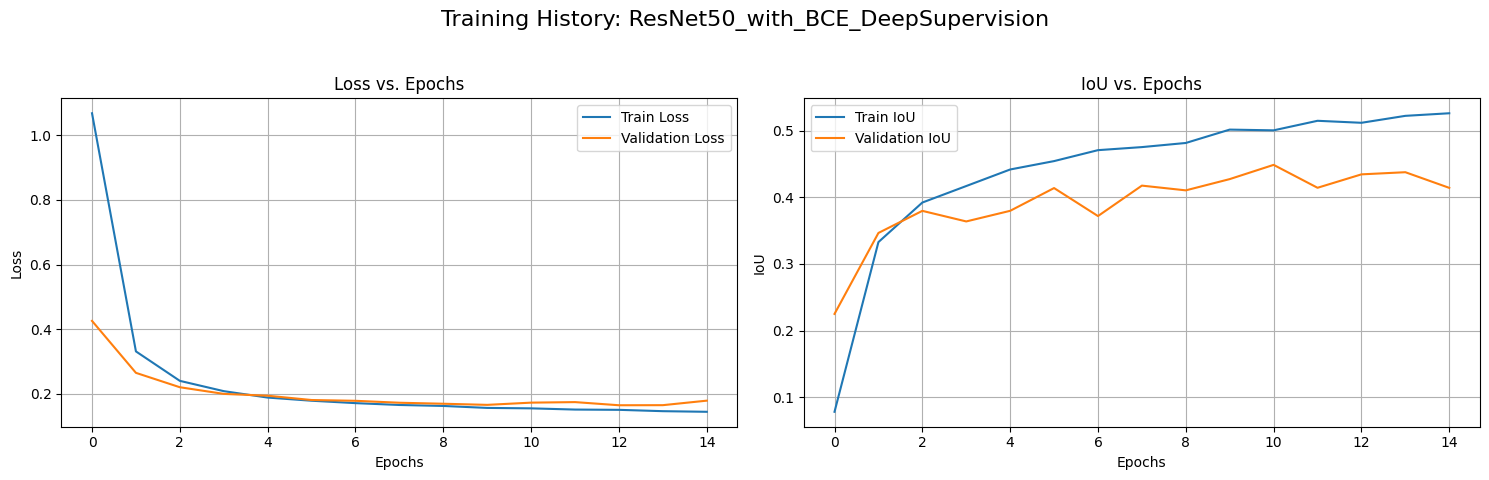


--- Visualizing best model for ResNet50_with_BCE_DeepSupervision ---
Loading best saved model from: best_model_ResNet50_with_BCE_DeepSupervision.pth


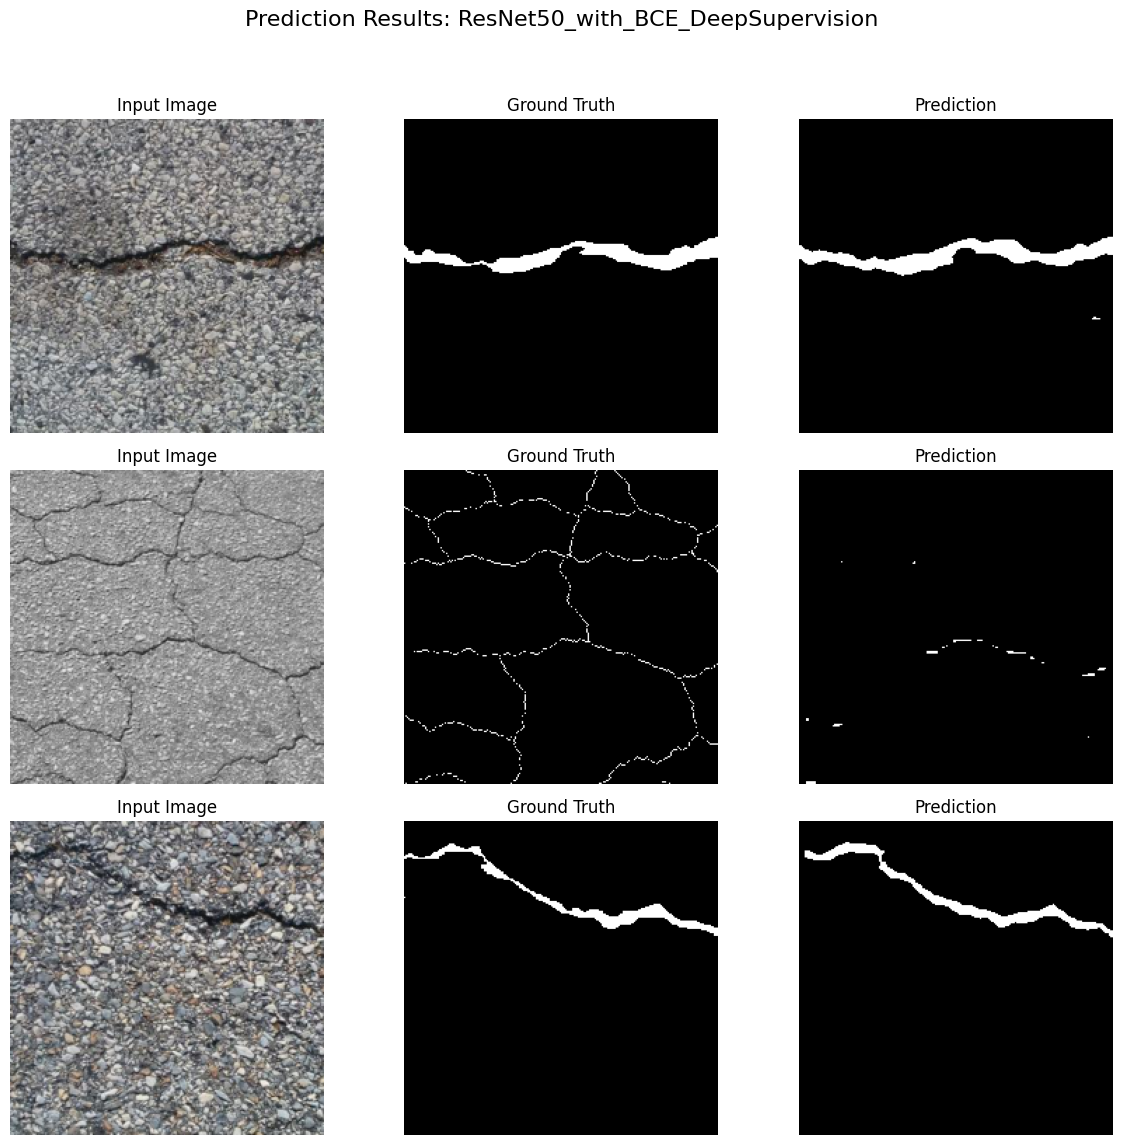


STARTING EXPERIMENT: ResNet50_with_Dice_DeepSupervision


Epoch 1/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 21.69it/s, iou=0.0255, loss=2.77]


Epoch 1/15 -> Train Loss: 2.7860, Train IoU: 0.0202 | Val Loss: 2.7477, Val IoU: 0.0263
** New best model saved with Val IoU: 0.0263 **


Epoch 2/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.93it/s, iou=0.0656, loss=2.47]


Epoch 2/15 -> Train Loss: 2.5620, Train IoU: 0.0403 | Val Loss: 2.4199, Val IoU: 0.0630
** New best model saved with Val IoU: 0.0630 **


Epoch 3/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.45it/s, iou=0.0886, loss=2.67]


Epoch 3/15 -> Train Loss: 2.1045, Train IoU: 0.2263 | Val Loss: 2.0496, Val IoU: 0.3322
** New best model saved with Val IoU: 0.3322 **


Epoch 4/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.07it/s, iou=0.364, loss=1.85]


Epoch 4/15 -> Train Loss: 1.6131, Train IoU: 0.5023 | Val Loss: 1.7274, Val IoU: 0.4436
** New best model saved with Val IoU: 0.4436 **


Epoch 5/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.50it/s, iou=0.364, loss=1.88]


Epoch 5/15 -> Train Loss: 1.5519, Train IoU: 0.5165 | Val Loss: 1.6976, Val IoU: 0.4547
** New best model saved with Val IoU: 0.4547 **


Epoch 6/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.33it/s, iou=0.14, loss=2.48]


Epoch 6/15 -> Train Loss: 1.5043, Train IoU: 0.5297 | Val Loss: 1.8217, Val IoU: 0.3940


Epoch 7/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.13it/s, iou=0.381, loss=1.78]


Epoch 7/15 -> Train Loss: 1.4718, Train IoU: 0.5373 | Val Loss: 1.6610, Val IoU: 0.4436


Epoch 8/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.60it/s, iou=0.378, loss=1.78]


Epoch 8/15 -> Train Loss: 1.4259, Train IoU: 0.5501 | Val Loss: 1.6431, Val IoU: 0.4553
** New best model saved with Val IoU: 0.4553 **


Epoch 9/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.43it/s, iou=0.385, loss=1.72]


Epoch 9/15 -> Train Loss: 1.3902, Train IoU: 0.5497 | Val Loss: 1.5665, Val IoU: 0.4645
** New best model saved with Val IoU: 0.4645 **


Epoch 10/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.13it/s, iou=0.395, loss=1.62]


Epoch 10/15 -> Train Loss: 1.2590, Train IoU: 0.5586 | Val Loss: 1.4711, Val IoU: 0.4595


Epoch 11/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.21it/s, iou=0.385, loss=1.59]


Epoch 11/15 -> Train Loss: 1.1910, Train IoU: 0.5569 | Val Loss: 1.4131, Val IoU: 0.4603


Epoch 12/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.71it/s, iou=0.399, loss=1.55]


Epoch 12/15 -> Train Loss: 1.1497, Train IoU: 0.5624 | Val Loss: 1.3894, Val IoU: 0.4685
** New best model saved with Val IoU: 0.4685 **


Epoch 13/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.66it/s, iou=0.391, loss=1.56]


Epoch 13/15 -> Train Loss: 1.1208, Train IoU: 0.5695 | Val Loss: 1.3595, Val IoU: 0.4757
** New best model saved with Val IoU: 0.4757 **


Epoch 14/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.23it/s, iou=0.402, loss=1.52]


Epoch 14/15 -> Train Loss: 1.1091, Train IoU: 0.5728 | Val Loss: 1.4046, Val IoU: 0.4574


Epoch 15/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.63it/s, iou=0.404, loss=1.53]


Epoch 15/15 -> Train Loss: 1.0932, Train IoU: 0.5755 | Val Loss: 1.3565, Val IoU: 0.4753


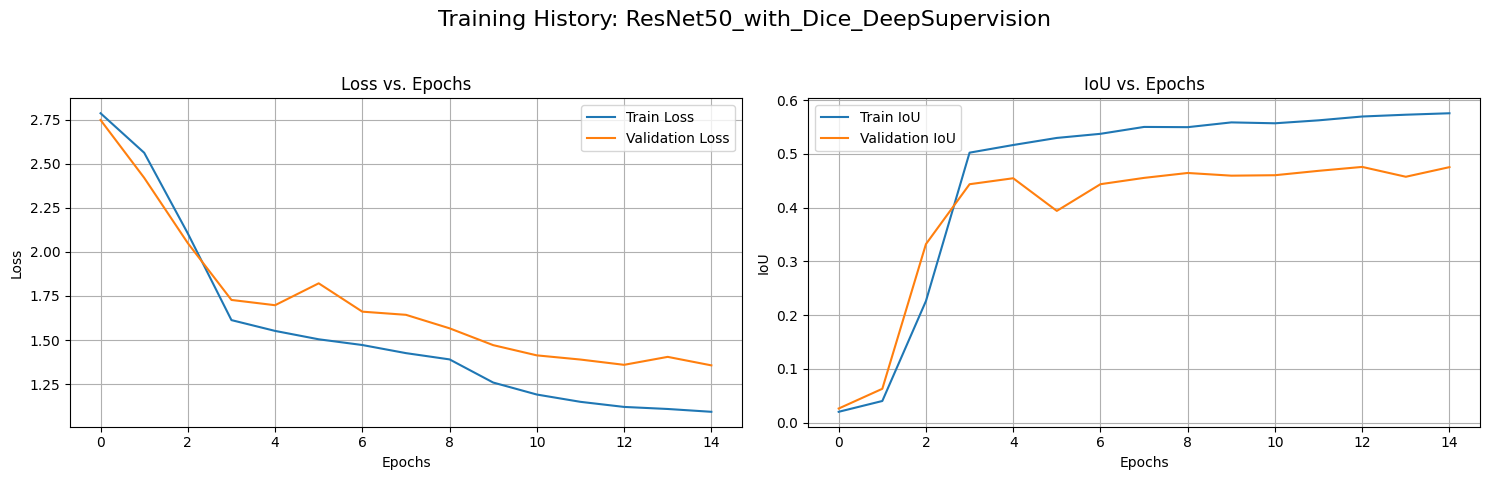


--- Visualizing best model for ResNet50_with_Dice_DeepSupervision ---
Loading best saved model from: best_model_ResNet50_with_Dice_DeepSupervision.pth


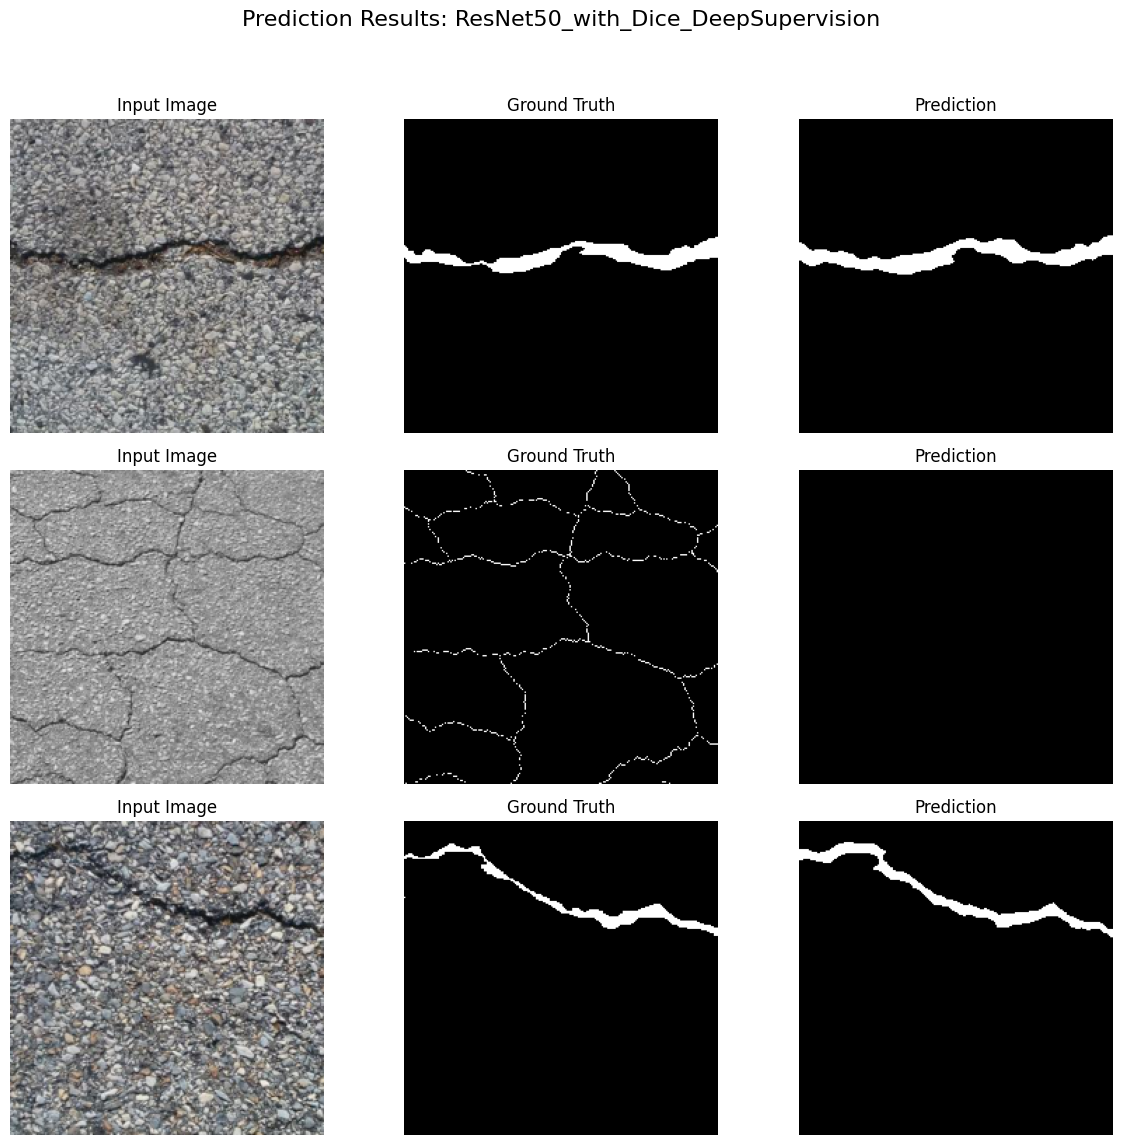


STARTING EXPERIMENT: ResNet50_with_Focal_DeepSupervision


Epoch 1/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.70it/s, iou=0.0722, loss=0.0831]


Epoch 1/15 -> Train Loss: 0.1340, Train IoU: 0.1217 | Val Loss: 0.0753, Val IoU: 0.1547
** New best model saved with Val IoU: 0.1547 **


Epoch 2/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.58it/s, iou=0.202, loss=0.0613]


Epoch 2/15 -> Train Loss: 0.0616, Train IoU: 0.2625 | Val Loss: 0.0572, Val IoU: 0.2532
** New best model saved with Val IoU: 0.2532 **


Epoch 3/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.70it/s, iou=0.229, loss=0.0579]


Epoch 3/15 -> Train Loss: 0.0516, Train IoU: 0.2978 | Val Loss: 0.0520, Val IoU: 0.2857
** New best model saved with Val IoU: 0.2857 **


Epoch 4/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.57it/s, iou=0.24, loss=0.0544]


Epoch 4/15 -> Train Loss: 0.0468, Train IoU: 0.3395 | Val Loss: 0.0493, Val IoU: 0.2815


Epoch 5/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.73it/s, iou=0.23, loss=0.0524]


Epoch 5/15 -> Train Loss: 0.0438, Train IoU: 0.3717 | Val Loss: 0.0482, Val IoU: 0.2747


Epoch 6/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.38it/s, iou=0.287, loss=0.0501]


Epoch 6/15 -> Train Loss: 0.0415, Train IoU: 0.3915 | Val Loss: 0.0464, Val IoU: 0.3391
** New best model saved with Val IoU: 0.3391 **


Epoch 7/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.15it/s, iou=0.238, loss=0.0497]


Epoch 7/15 -> Train Loss: 0.0398, Train IoU: 0.4030 | Val Loss: 0.0443, Val IoU: 0.3138


Epoch 8/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.60it/s, iou=0.296, loss=0.0491]


Epoch 8/15 -> Train Loss: 0.0398, Train IoU: 0.4004 | Val Loss: 0.0442, Val IoU: 0.3765
** New best model saved with Val IoU: 0.3765 **


Epoch 9/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.39it/s, iou=0.339, loss=0.047]


Epoch 9/15 -> Train Loss: 0.0376, Train IoU: 0.4259 | Val Loss: 0.0436, Val IoU: 0.3798
** New best model saved with Val IoU: 0.3798 **


Epoch 10/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.79it/s, iou=0.302, loss=0.046]


Epoch 10/15 -> Train Loss: 0.0360, Train IoU: 0.4342 | Val Loss: 0.0437, Val IoU: 0.3678


Epoch 11/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 21.56it/s, iou=0.319, loss=0.0457]


Epoch 11/15 -> Train Loss: 0.0352, Train IoU: 0.4475 | Val Loss: 0.0431, Val IoU: 0.3786


Epoch 12/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.04it/s, iou=0.325, loss=0.0452]


Epoch 12/15 -> Train Loss: 0.0347, Train IoU: 0.4463 | Val Loss: 0.0421, Val IoU: 0.3887
** New best model saved with Val IoU: 0.3887 **


Epoch 13/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.43it/s, iou=0.33, loss=0.0448]


Epoch 13/15 -> Train Loss: 0.0338, Train IoU: 0.4601 | Val Loss: 0.0414, Val IoU: 0.3661


Epoch 14/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.80it/s, iou=0.284, loss=0.045]


Epoch 14/15 -> Train Loss: 0.0334, Train IoU: 0.4648 | Val Loss: 0.0427, Val IoU: 0.3474


Epoch 15/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.46it/s, iou=0.332, loss=0.044]


Epoch 15/15 -> Train Loss: 0.0326, Train IoU: 0.4709 | Val Loss: 0.0407, Val IoU: 0.3705


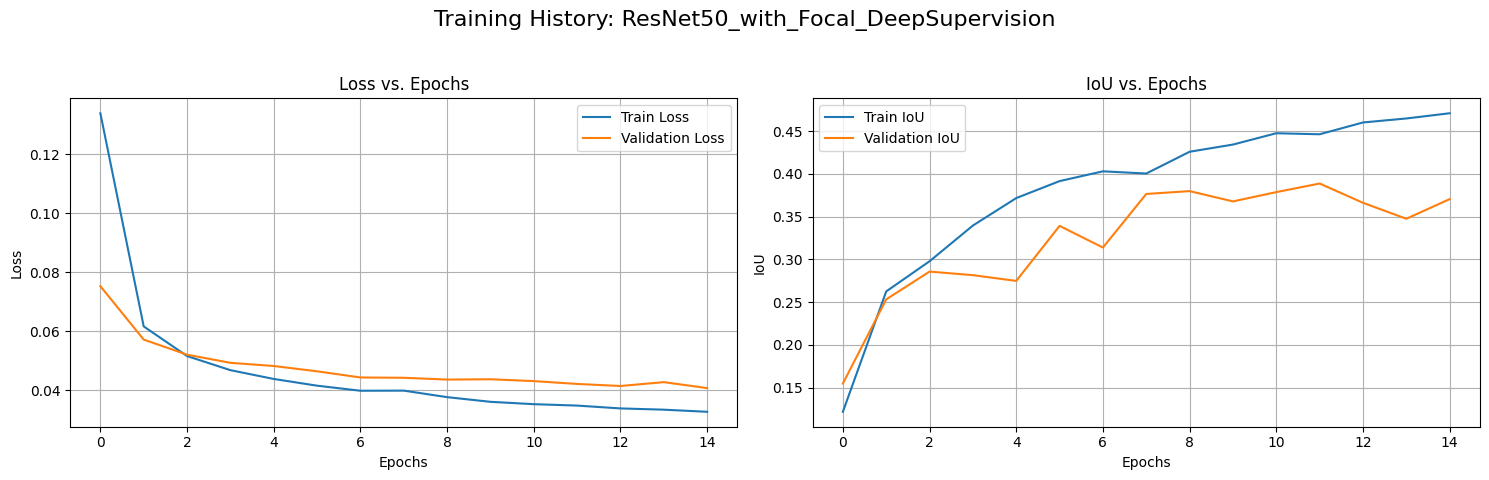


--- Visualizing best model for ResNet50_with_Focal_DeepSupervision ---
Loading best saved model from: best_model_ResNet50_with_Focal_DeepSupervision.pth


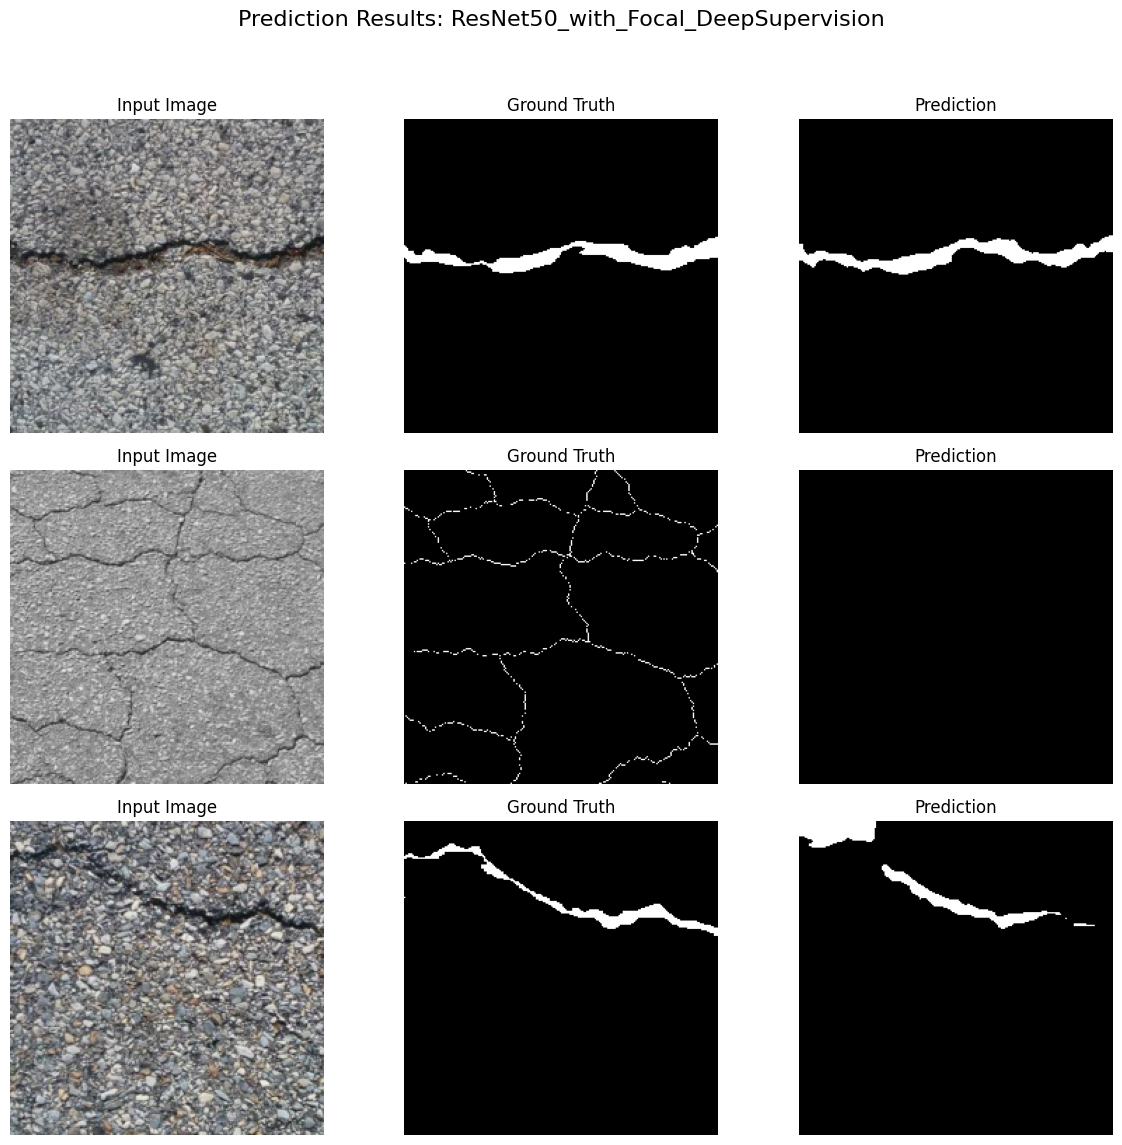


STARTING EXPERIMENT: ResNet50_with_DiceFocal_DeepSupervision


Epoch 1/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.56it/s, iou=0.169, loss=1.42]


Epoch 1/15 -> Train Loss: 1.5006, Train IoU: 0.1629 | Val Loss: 1.3738, Val IoU: 0.2643
** New best model saved with Val IoU: 0.2643 **


Epoch 2/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.73it/s, iou=0.345, loss=1.11]


Epoch 2/15 -> Train Loss: 1.0766, Train IoU: 0.4708 | Val Loss: 1.0107, Val IoU: 0.4314
** New best model saved with Val IoU: 0.4314 **


Epoch 3/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.59it/s, iou=0.372, loss=1.03]


Epoch 3/15 -> Train Loss: 0.9008, Train IoU: 0.5023 | Val Loss: 0.9435, Val IoU: 0.4447
** New best model saved with Val IoU: 0.4447 **


Epoch 4/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 20.94it/s, iou=0.381, loss=0.988]


Epoch 4/15 -> Train Loss: 0.8256, Train IoU: 0.5223 | Val Loss: 0.9026, Val IoU: 0.4402


Epoch 5/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.53it/s, iou=0.384, loss=0.947]


Epoch 5/15 -> Train Loss: 0.7703, Train IoU: 0.5272 | Val Loss: 0.8400, Val IoU: 0.4584
** New best model saved with Val IoU: 0.4584 **


Epoch 6/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.51it/s, iou=0.386, loss=0.914]


Epoch 6/15 -> Train Loss: 0.7286, Train IoU: 0.5336 | Val Loss: 0.8187, Val IoU: 0.4646
** New best model saved with Val IoU: 0.4646 **


Epoch 7/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.80it/s, iou=0.402, loss=0.894]


Epoch 7/15 -> Train Loss: 0.6957, Train IoU: 0.5472 | Val Loss: 0.8268, Val IoU: 0.4515


Epoch 8/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.45it/s, iou=0.392, loss=0.9]


Epoch 8/15 -> Train Loss: 0.6978, Train IoU: 0.5399 | Val Loss: 0.8076, Val IoU: 0.4655
** New best model saved with Val IoU: 0.4655 **


Epoch 9/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.46it/s, iou=0.393, loss=0.88]


Epoch 9/15 -> Train Loss: 0.6601, Train IoU: 0.5642 | Val Loss: 0.7951, Val IoU: 0.4644


Epoch 10/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.48it/s, iou=0.387, loss=0.885]


Epoch 10/15 -> Train Loss: 0.6482, Train IoU: 0.5715 | Val Loss: 0.7958, Val IoU: 0.4624


Epoch 11/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 21.77it/s, iou=0.417, loss=0.857]


Epoch 11/15 -> Train Loss: 0.6412, Train IoU: 0.5729 | Val Loss: 0.7825, Val IoU: 0.4732
** New best model saved with Val IoU: 0.4732 **


Epoch 12/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.36it/s, iou=0.408, loss=0.868]


Epoch 12/15 -> Train Loss: 0.6305, Train IoU: 0.5797 | Val Loss: 0.7775, Val IoU: 0.4781
** New best model saved with Val IoU: 0.4781 **


Epoch 13/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.93it/s, iou=0.407, loss=0.867]


Epoch 13/15 -> Train Loss: 0.6193, Train IoU: 0.5866 | Val Loss: 0.7733, Val IoU: 0.4749


Epoch 14/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.96it/s, iou=0.417, loss=0.857]


Epoch 14/15 -> Train Loss: 0.6172, Train IoU: 0.5865 | Val Loss: 0.7745, Val IoU: 0.4751


Epoch 15/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.75it/s, iou=0.413, loss=0.854]


Epoch 15/15 -> Train Loss: 0.6132, Train IoU: 0.5892 | Val Loss: 0.7854, Val IoU: 0.4672


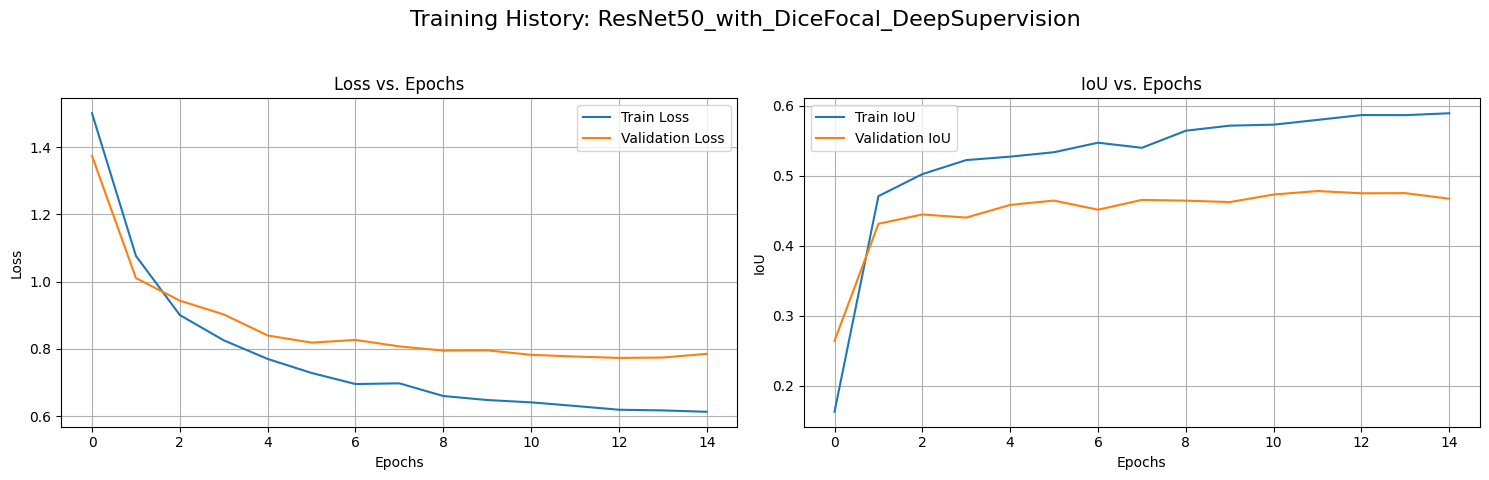


--- Visualizing best model for ResNet50_with_DiceFocal_DeepSupervision ---
Loading best saved model from: best_model_ResNet50_with_DiceFocal_DeepSupervision.pth


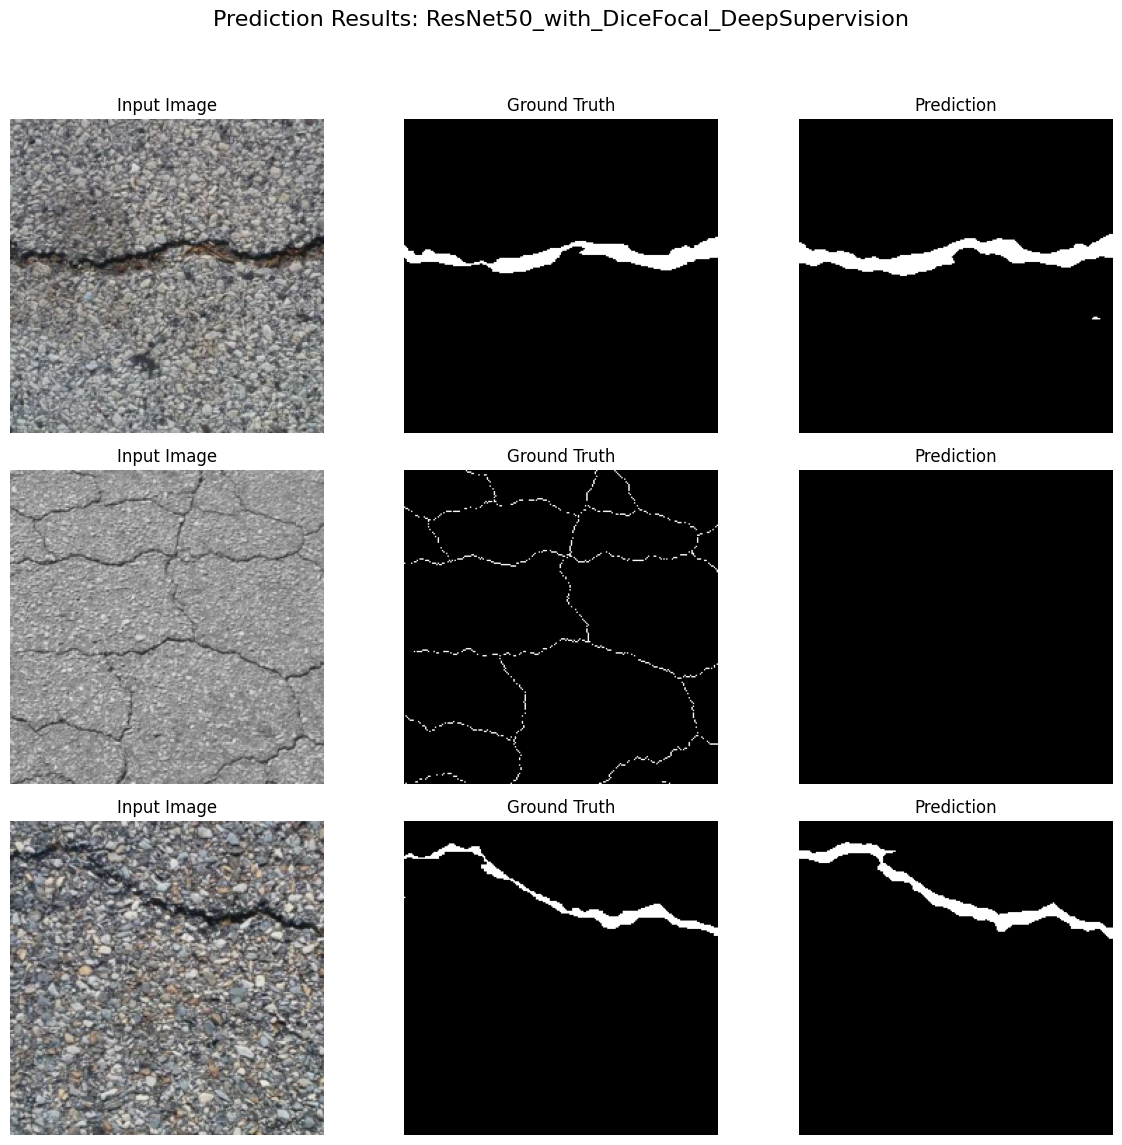

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth



STARTING EXPERIMENT: EfficientNetB0_with_BCE_DeepSupervision


100%|██████████| 20.5M/20.5M [00:00<00:00, 134MB/s] 
Epoch 1/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.60it/s, iou=0.0449, loss=2.59]


Epoch 1/15 -> Train Loss: 2.8451, Train IoU: 0.0455 | Val Loss: 2.6106, Val IoU: 0.0366
** New best model saved with Val IoU: 0.0366 **


Epoch 2/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.47it/s, iou=0.0661, loss=1.88]


Epoch 2/15 -> Train Loss: 2.0045, Train IoU: 0.0533 | Val Loss: 1.8861, Val IoU: 0.0583
** New best model saved with Val IoU: 0.0583 **


Epoch 3/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.99it/s, iou=0.129, loss=1.54]


Epoch 3/15 -> Train Loss: 1.5953, Train IoU: 0.1093 | Val Loss: 1.5165, Val IoU: 0.1311
** New best model saved with Val IoU: 0.1311 **


Epoch 4/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.34it/s, iou=0.236, loss=1.19]


Epoch 4/15 -> Train Loss: 1.2923, Train IoU: 0.2359 | Val Loss: 1.3422, Val IoU: 0.2735
** New best model saved with Val IoU: 0.2735 **


Epoch 5/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.65it/s, iou=0.28, loss=1.04]


Epoch 5/15 -> Train Loss: 1.0429, Train IoU: 0.3472 | Val Loss: 1.1031, Val IoU: 0.3388
** New best model saved with Val IoU: 0.3388 **


Epoch 6/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.12it/s, iou=0.333, loss=0.82]


Epoch 6/15 -> Train Loss: 0.8517, Train IoU: 0.3863 | Val Loss: 0.8236, Val IoU: 0.3696
** New best model saved with Val IoU: 0.3696 **


Epoch 7/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.25it/s, iou=0.338, loss=0.766]


Epoch 7/15 -> Train Loss: 0.7190, Train IoU: 0.4023 | Val Loss: 0.7111, Val IoU: 0.3884
** New best model saved with Val IoU: 0.3884 **


Epoch 8/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.06it/s, iou=0.334, loss=0.607]


Epoch 8/15 -> Train Loss: 0.6214, Train IoU: 0.4008 | Val Loss: 0.6329, Val IoU: 0.3402


Epoch 9/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.41it/s, iou=0.349, loss=0.59]


Epoch 9/15 -> Train Loss: 0.5676, Train IoU: 0.4060 | Val Loss: 0.5661, Val IoU: 0.3809


Epoch 10/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.69it/s, iou=0.357, loss=0.597]


Epoch 10/15 -> Train Loss: 0.5151, Train IoU: 0.4173 | Val Loss: 0.5767, Val IoU: 0.3876


Epoch 11/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.29it/s, iou=0.345, loss=0.516]


Epoch 11/15 -> Train Loss: 0.4822, Train IoU: 0.4115 | Val Loss: 0.9497, Val IoU: 0.3525


Epoch 12/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.76it/s, iou=0.356, loss=0.499]


Epoch 12/15 -> Train Loss: 0.4571, Train IoU: 0.4185 | Val Loss: 0.5508, Val IoU: 0.3735


Epoch 13/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.05it/s, iou=0.357, loss=0.469]


Epoch 13/15 -> Train Loss: 0.4273, Train IoU: 0.4164 | Val Loss: 0.5655, Val IoU: 0.3685


Epoch 14/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.43it/s, iou=0.347, loss=0.433]


Epoch 14/15 -> Train Loss: 0.4062, Train IoU: 0.4210 | Val Loss: 0.4599, Val IoU: 0.3583


Epoch 15/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.38it/s, iou=0.351, loss=0.421]


Epoch 15/15 -> Train Loss: 0.3810, Train IoU: 0.4232 | Val Loss: 0.8337, Val IoU: 0.3555


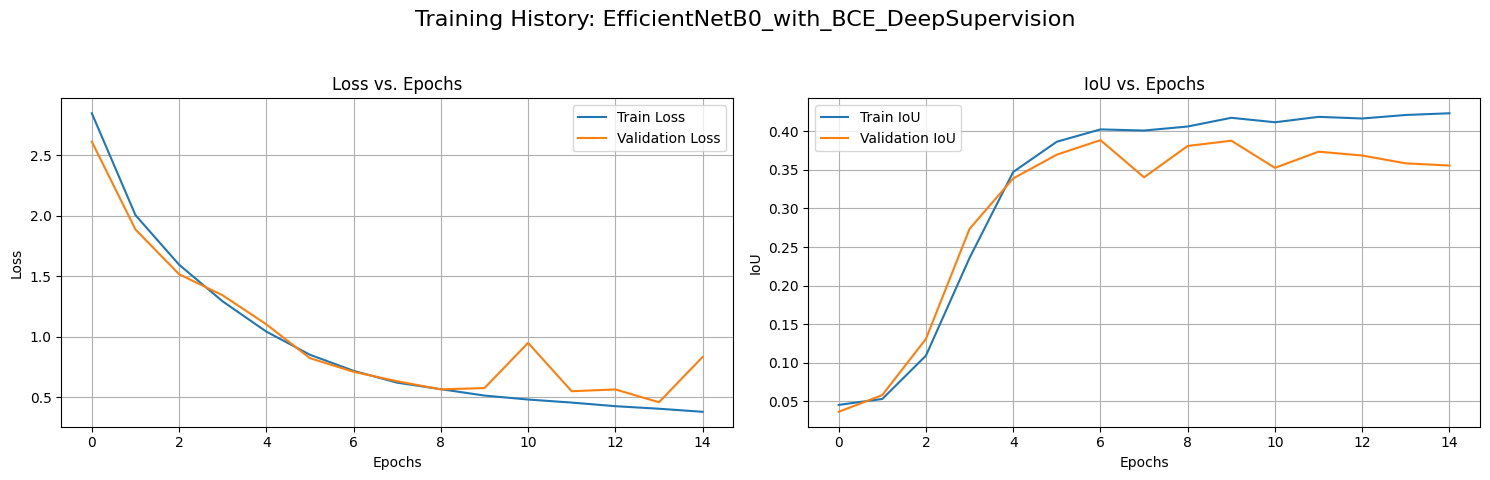


--- Visualizing best model for EfficientNetB0_with_BCE_DeepSupervision ---
Loading best saved model from: best_model_EfficientNetB0_with_BCE_DeepSupervision.pth


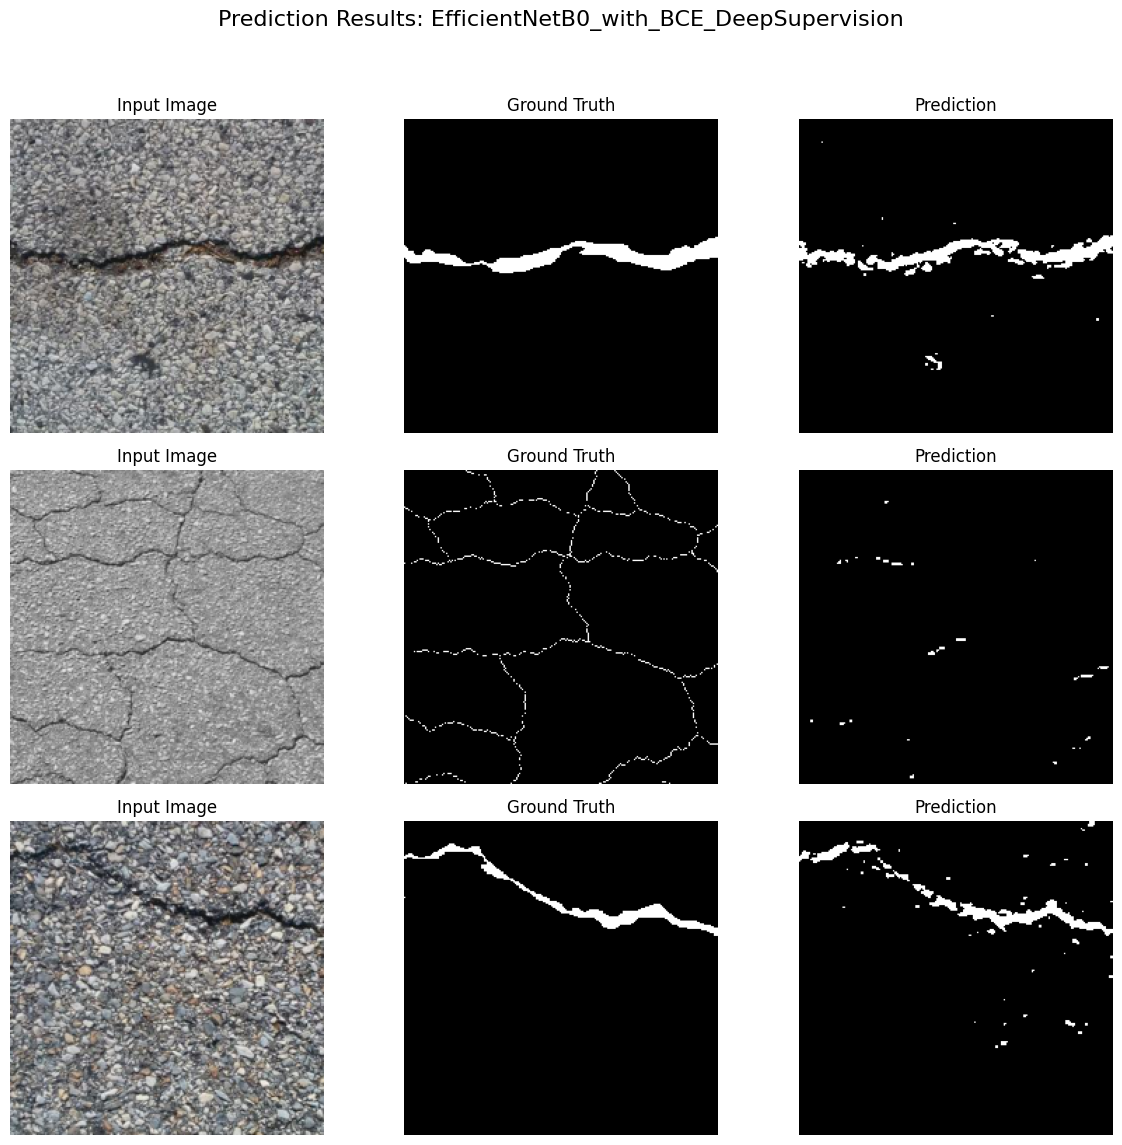


STARTING EXPERIMENT: EfficientNetB0_with_Dice_DeepSupervision


Epoch 1/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.71it/s, iou=0.076, loss=3.23]


Epoch 1/15 -> Train Loss: 3.2467, Train IoU: 0.0625 | Val Loss: 3.2245, Val IoU: 0.0721
** New best model saved with Val IoU: 0.0721 **


Epoch 2/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.81it/s, iou=0.108, loss=3.13]


Epoch 2/15 -> Train Loss: 3.1051, Train IoU: 0.0936 | Val Loss: 3.1122, Val IoU: 0.0932
** New best model saved with Val IoU: 0.0932 **


Epoch 3/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 21.37it/s, iou=0.129, loss=2.98]


Epoch 3/15 -> Train Loss: 2.9483, Train IoU: 0.1097 | Val Loss: 2.9516, Val IoU: 0.1053
** New best model saved with Val IoU: 0.1053 **


Epoch 4/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.24it/s, iou=0.142, loss=2.76]


Epoch 4/15 -> Train Loss: 2.7591, Train IoU: 0.1255 | Val Loss: 2.7490, Val IoU: 0.1163
** New best model saved with Val IoU: 0.1163 **


Epoch 5/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.23it/s, iou=0.125, loss=2.75]


Epoch 5/15 -> Train Loss: 2.6267, Train IoU: 0.1465 | Val Loss: 2.6777, Val IoU: 0.1268
** New best model saved with Val IoU: 0.1268 **


Epoch 6/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.42it/s, iou=0.136, loss=2.67]


Epoch 6/15 -> Train Loss: 2.5170, Train IoU: 0.1767 | Val Loss: 2.6106, Val IoU: 0.1440
** New best model saved with Val IoU: 0.1440 **


Epoch 7/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.81it/s, iou=0.0474, loss=2.87]


Epoch 7/15 -> Train Loss: 2.3506, Train IoU: 0.2182 | Val Loss: 2.6275, Val IoU: 0.1099


Epoch 8/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.82it/s, iou=0.307, loss=2.38]


Epoch 8/15 -> Train Loss: 2.2381, Train IoU: 0.2558 | Val Loss: 2.2617, Val IoU: 0.3227
** New best model saved with Val IoU: 0.3227 **


Epoch 9/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.88it/s, iou=0.335, loss=2.28]


Epoch 9/15 -> Train Loss: 2.1514, Train IoU: 0.3040 | Val Loss: 2.2357, Val IoU: 0.3116


Epoch 10/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 21.59it/s, iou=0.338, loss=2.18]


Epoch 10/15 -> Train Loss: 2.0901, Train IoU: 0.3363 | Val Loss: 2.1126, Val IoU: 0.3704
** New best model saved with Val IoU: 0.3704 **


Epoch 11/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.51it/s, iou=0.345, loss=2.16]


Epoch 11/15 -> Train Loss: 2.0223, Train IoU: 0.3717 | Val Loss: 2.0414, Val IoU: 0.4031
** New best model saved with Val IoU: 0.4031 **


Epoch 12/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.64it/s, iou=0.292, loss=2.2]


Epoch 12/15 -> Train Loss: 1.9747, Train IoU: 0.3983 | Val Loss: 2.0566, Val IoU: 0.3797


Epoch 13/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.10it/s, iou=0.34, loss=2.13]


Epoch 13/15 -> Train Loss: 1.9570, Train IoU: 0.4028 | Val Loss: 2.0536, Val IoU: 0.3624


Epoch 14/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 20.89it/s, iou=0.308, loss=2.2]


Epoch 14/15 -> Train Loss: 1.9153, Train IoU: 0.4169 | Val Loss: 2.0644, Val IoU: 0.3794


Epoch 15/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.86it/s, iou=0.361, loss=2.11]


Epoch 15/15 -> Train Loss: 1.8700, Train IoU: 0.4408 | Val Loss: 2.0103, Val IoU: 0.3984


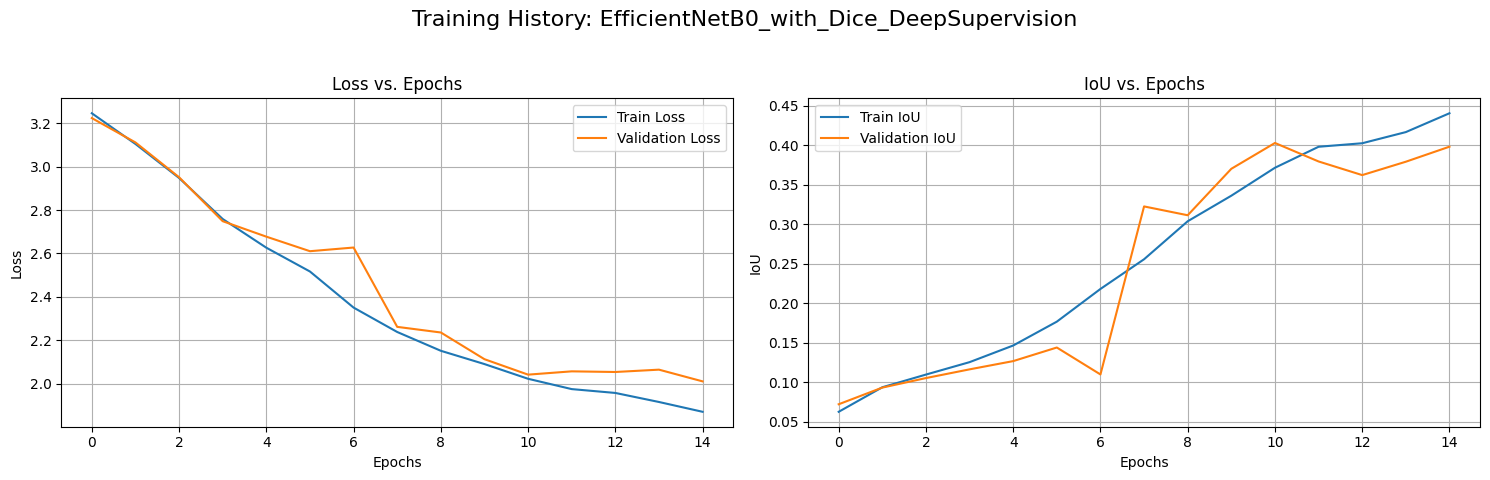


--- Visualizing best model for EfficientNetB0_with_Dice_DeepSupervision ---
Loading best saved model from: best_model_EfficientNetB0_with_Dice_DeepSupervision.pth


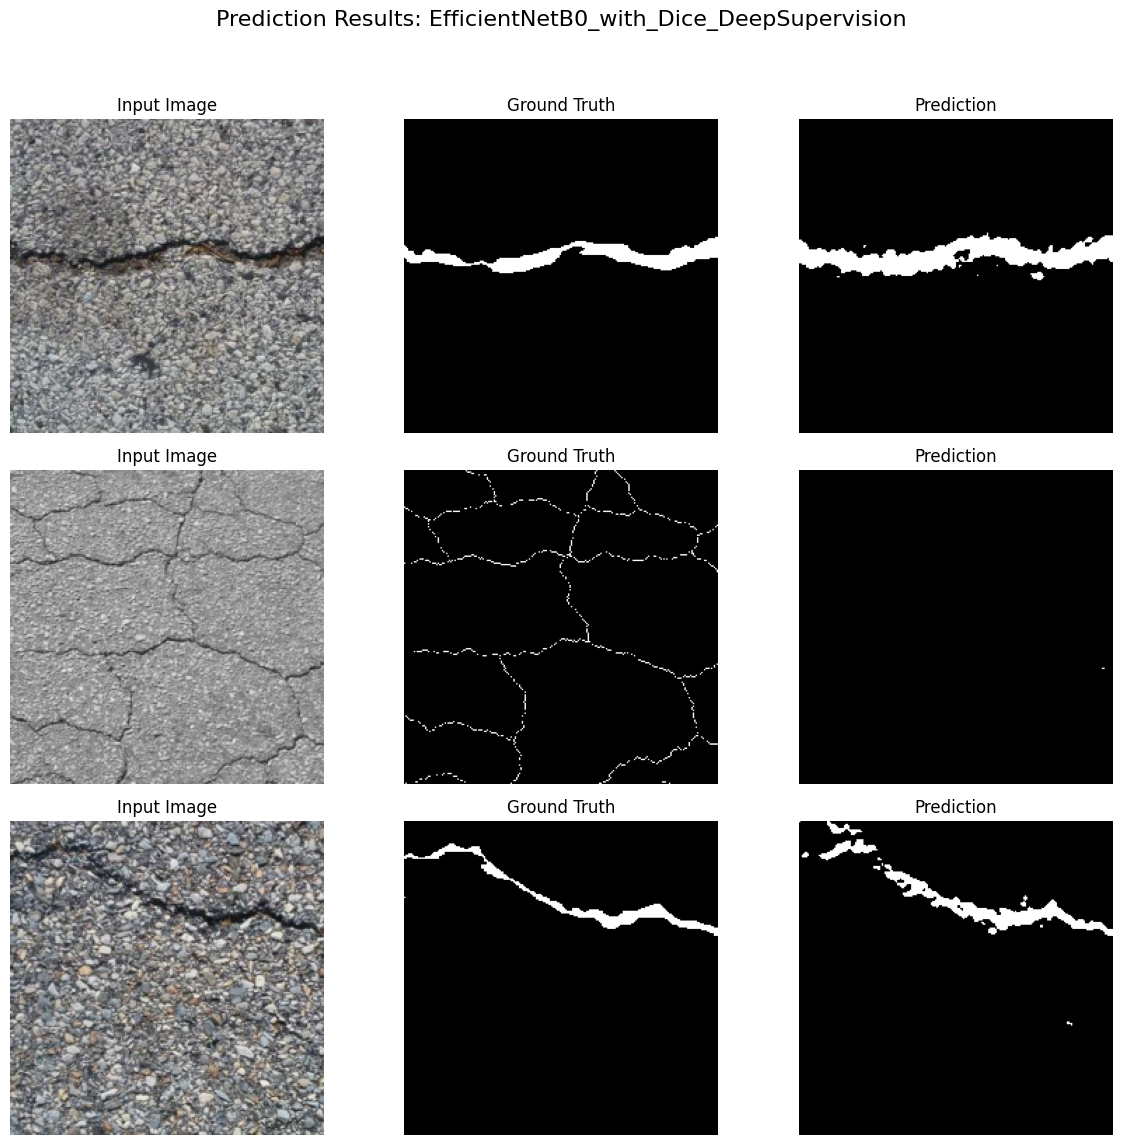


STARTING EXPERIMENT: EfficientNetB0_with_Focal_DeepSupervision


Epoch 1/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.03it/s, iou=0.0183, loss=0.934]


Epoch 1/15 -> Train Loss: 1.1471, Train IoU: 0.0187 | Val Loss: 1.3360, Val IoU: 0.0211
** New best model saved with Val IoU: 0.0211 **


Epoch 2/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.17it/s, iou=0.0216, loss=0.642]


Epoch 2/15 -> Train Loss: 0.7026, Train IoU: 0.0254 | Val Loss: 0.6307, Val IoU: 0.0240
** New best model saved with Val IoU: 0.0240 **


Epoch 3/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.89it/s, iou=0.0222, loss=0.543]


Epoch 3/15 -> Train Loss: 0.5554, Train IoU: 0.0277 | Val Loss: 0.5771, Val IoU: 0.0248
** New best model saved with Val IoU: 0.0248 **


Epoch 4/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.94it/s, iou=0.0252, loss=0.478]


Epoch 4/15 -> Train Loss: 0.4635, Train IoU: 0.0282 | Val Loss: 0.4740, Val IoU: 0.0262
** New best model saved with Val IoU: 0.0262 **


Epoch 5/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.28it/s, iou=0.0255, loss=0.382]


Epoch 5/15 -> Train Loss: 0.3873, Train IoU: 0.0283 | Val Loss: 0.4377, Val IoU: 0.0262
** New best model saved with Val IoU: 0.0262 **


Epoch 6/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 21.64it/s, iou=0.0269, loss=0.299]


Epoch 6/15 -> Train Loss: 0.3171, Train IoU: 0.0285 | Val Loss: 0.4728, Val IoU: 0.0272
** New best model saved with Val IoU: 0.0272 **


Epoch 7/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.85it/s, iou=0.0582, loss=0.253]


Epoch 7/15 -> Train Loss: 0.2536, Train IoU: 0.0449 | Val Loss: 1.4527, Val IoU: 0.0663
** New best model saved with Val IoU: 0.0663 **


Epoch 8/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.64it/s, iou=0.173, loss=0.19]


Epoch 8/15 -> Train Loss: 0.1955, Train IoU: 0.1579 | Val Loss: 0.4689, Val IoU: 0.2121
** New best model saved with Val IoU: 0.2121 **


Epoch 9/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.31it/s, iou=0.244, loss=0.155]


Epoch 9/15 -> Train Loss: 0.1489, Train IoU: 0.3079 | Val Loss: 0.2279, Val IoU: 0.2916
** New best model saved with Val IoU: 0.2916 **


Epoch 10/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 21.56it/s, iou=0.318, loss=0.135]


Epoch 10/15 -> Train Loss: 0.1197, Train IoU: 0.3439 | Val Loss: 0.1854, Val IoU: 0.3076
** New best model saved with Val IoU: 0.3076 **


Epoch 11/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.62it/s, iou=0.318, loss=0.111]


Epoch 11/15 -> Train Loss: 0.1006, Train IoU: 0.3523 | Val Loss: 0.0972, Val IoU: 0.3146
** New best model saved with Val IoU: 0.3146 **


Epoch 12/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.50it/s, iou=0.292, loss=0.106]


Epoch 12/15 -> Train Loss: 0.0881, Train IoU: 0.3484 | Val Loss: 0.1400, Val IoU: 0.2504


Epoch 13/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.37it/s, iou=0.304, loss=0.102]


Epoch 13/15 -> Train Loss: 0.0801, Train IoU: 0.3469 | Val Loss: 0.0872, Val IoU: 0.3063


Epoch 14/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.83it/s, iou=0.281, loss=0.0887]


Epoch 14/15 -> Train Loss: 0.0737, Train IoU: 0.3478 | Val Loss: 0.0763, Val IoU: 0.2837


Epoch 15/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 22.96it/s, iou=0.315, loss=0.0843]


Epoch 15/15 -> Train Loss: 0.0696, Train IoU: 0.3469 | Val Loss: 0.0736, Val IoU: 0.3190
** New best model saved with Val IoU: 0.3190 **


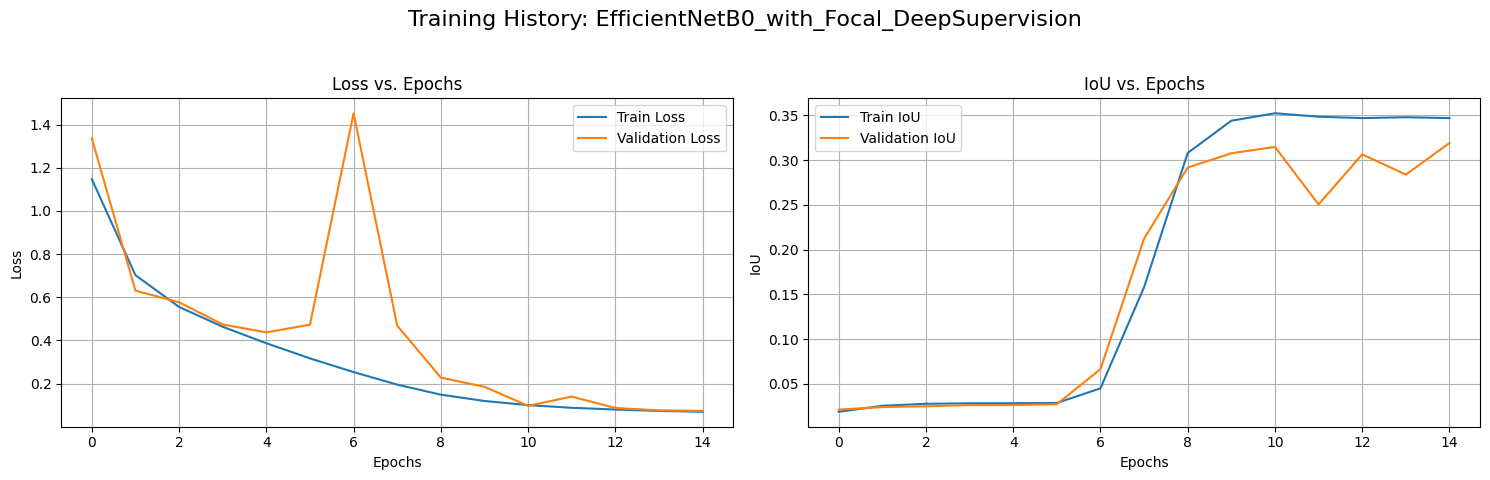


--- Visualizing best model for EfficientNetB0_with_Focal_DeepSupervision ---
Loading best saved model from: best_model_EfficientNetB0_with_Focal_DeepSupervision.pth


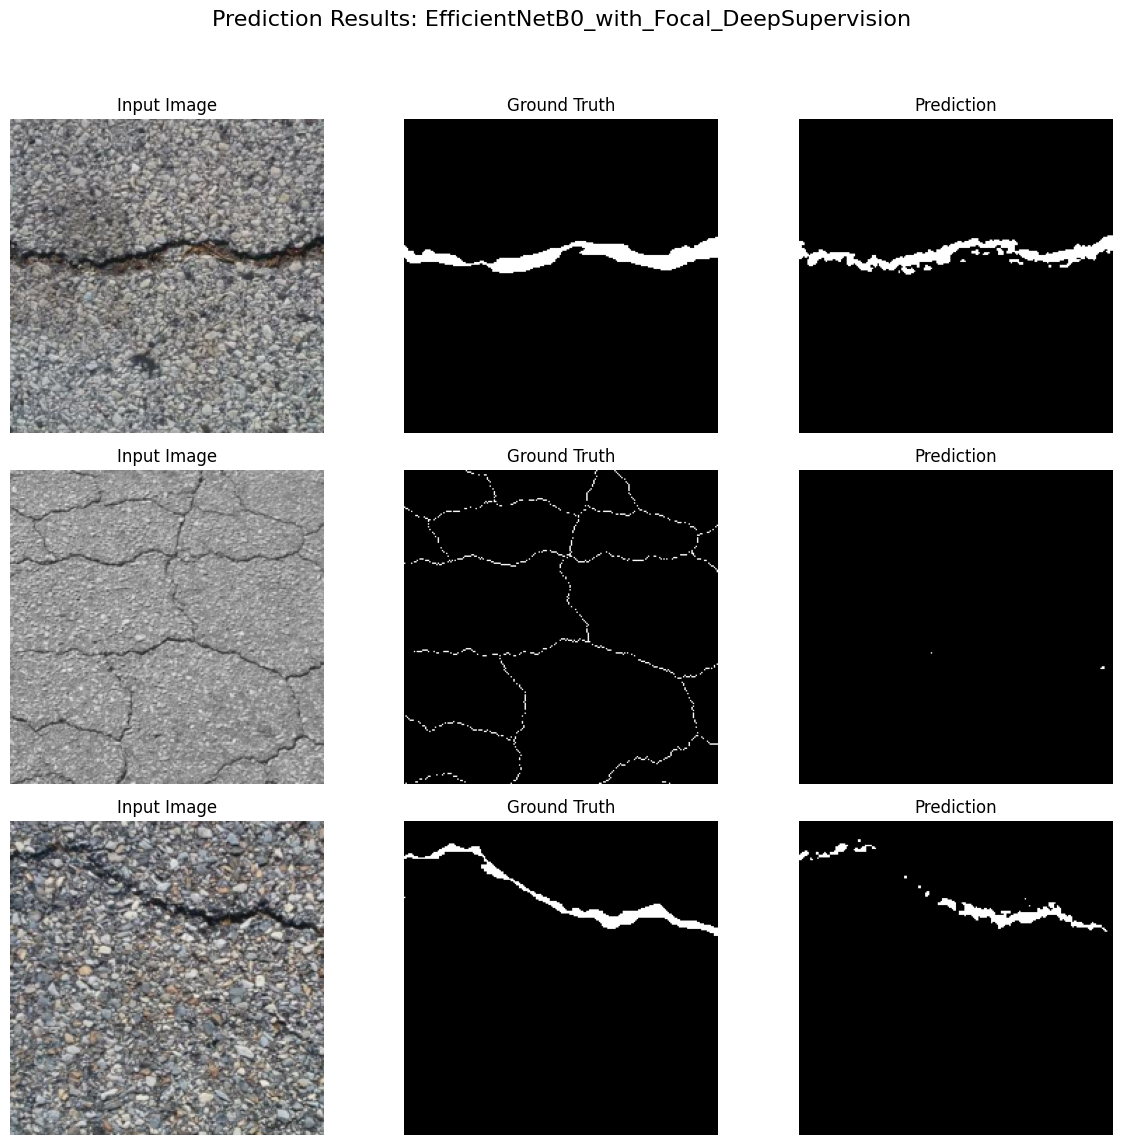


STARTING EXPERIMENT: EfficientNetB0_with_DiceFocal_DeepSupervision


Epoch 1/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.88it/s, iou=0.0737, loss=2.08]


Epoch 1/15 -> Train Loss: 2.2667, Train IoU: 0.0890 | Val Loss: 2.1514, Val IoU: 0.1087
** New best model saved with Val IoU: 0.1087 **


Epoch 2/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.33it/s, iou=0.232, loss=1.85]


Epoch 2/15 -> Train Loss: 1.8908, Train IoU: 0.2329 | Val Loss: 1.8486, Val IoU: 0.2532
** New best model saved with Val IoU: 0.2532 **


Epoch 3/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.29it/s, iou=0.304, loss=1.74]


Epoch 3/15 -> Train Loss: 1.7199, Train IoU: 0.3234 | Val Loss: 1.7759, Val IoU: 0.3045
** New best model saved with Val IoU: 0.3045 **


Epoch 4/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.94it/s, iou=0.331, loss=1.65]


Epoch 4/15 -> Train Loss: 1.5879, Train IoU: 0.3772 | Val Loss: 1.5771, Val IoU: 0.3629
** New best model saved with Val IoU: 0.3629 **


Epoch 5/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.20it/s, iou=0.346, loss=1.57]


Epoch 5/15 -> Train Loss: 1.4496, Train IoU: 0.4346 | Val Loss: 1.4795, Val IoU: 0.3680
** New best model saved with Val IoU: 0.3680 **


Epoch 6/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.35it/s, iou=0.357, loss=1.48]


Epoch 6/15 -> Train Loss: 1.3356, Train IoU: 0.4675 | Val Loss: 1.3970, Val IoU: 0.3800
** New best model saved with Val IoU: 0.3800 **


Epoch 7/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.17it/s, iou=0.365, loss=1.48]


Epoch 7/15 -> Train Loss: 1.2580, Train IoU: 0.4874 | Val Loss: 1.3735, Val IoU: 0.3878
** New best model saved with Val IoU: 0.3878 **


Epoch 8/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.77it/s, iou=0.367, loss=1.35]


Epoch 8/15 -> Train Loss: 1.1976, Train IoU: 0.5004 | Val Loss: 1.2922, Val IoU: 0.3894
** New best model saved with Val IoU: 0.3894 **


Epoch 9/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.44it/s, iou=0.365, loss=1.34]


Epoch 9/15 -> Train Loss: 1.1493, Train IoU: 0.5103 | Val Loss: 1.2528, Val IoU: 0.3960
** New best model saved with Val IoU: 0.3960 **


Epoch 10/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 21.44it/s, iou=0.375, loss=1.3]


Epoch 10/15 -> Train Loss: 1.1183, Train IoU: 0.5159 | Val Loss: 1.2194, Val IoU: 0.4169
** New best model saved with Val IoU: 0.4169 **


Epoch 11/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 21.33it/s, iou=0.373, loss=1.28]


Epoch 11/15 -> Train Loss: 1.0798, Train IoU: 0.5262 | Val Loss: 1.2490, Val IoU: 0.3954


Epoch 12/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 23.90it/s, iou=0.381, loss=1.27]


Epoch 12/15 -> Train Loss: 1.0548, Train IoU: 0.5352 | Val Loss: 1.1555, Val IoU: 0.4318
** New best model saved with Val IoU: 0.4318 **


Epoch 13/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.88it/s, iou=0.373, loss=1.27]


Epoch 13/15 -> Train Loss: 1.0406, Train IoU: 0.5346 | Val Loss: 1.1646, Val IoU: 0.4254


Epoch 14/15 [Val]: 100%|██████████| 50/50 [00:01<00:00, 25.15it/s, iou=0.37, loss=1.26]


Epoch 14/15 -> Train Loss: 1.0280, Train IoU: 0.5337 | Val Loss: 1.1859, Val IoU: 0.4120


Epoch 15/15 [Val]: 100%|██████████| 50/50 [00:02<00:00, 24.68it/s, iou=0.378, loss=1.25]


Epoch 15/15 -> Train Loss: 1.0153, Train IoU: 0.5397 | Val Loss: 1.1256, Val IoU: 0.4387
** New best model saved with Val IoU: 0.4387 **


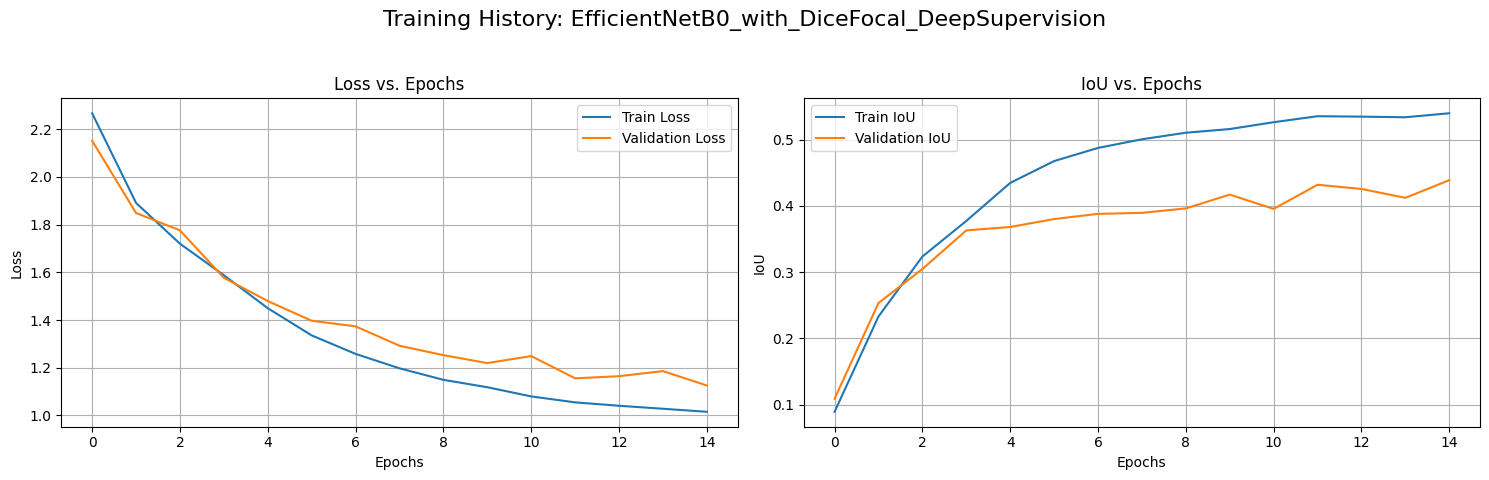


--- Visualizing best model for EfficientNetB0_with_DiceFocal_DeepSupervision ---
Loading best saved model from: best_model_EfficientNetB0_with_DiceFocal_DeepSupervision.pth


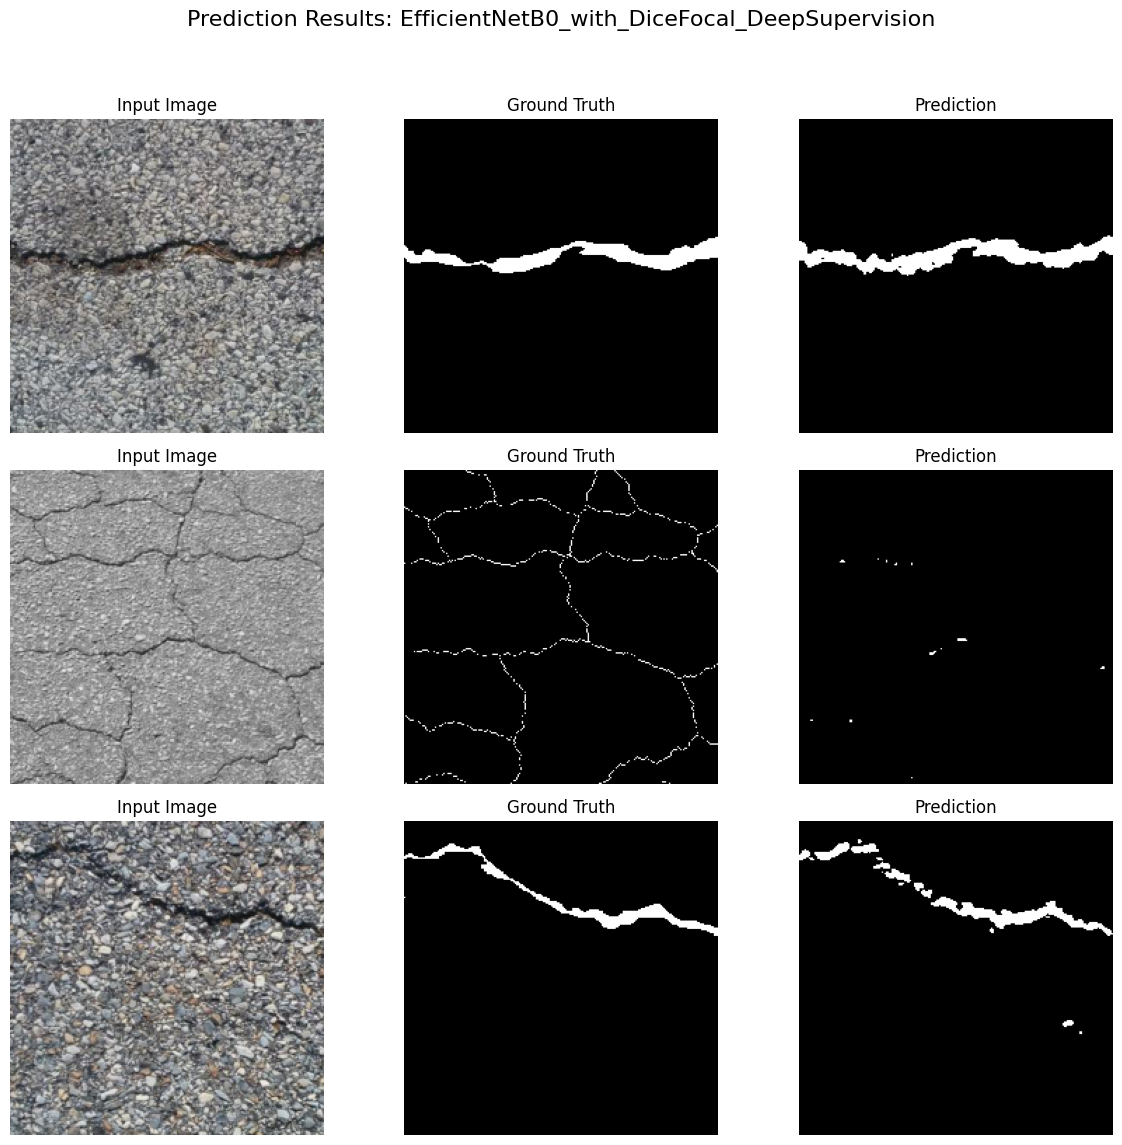



All experiments finished.


In [20]:
NUM_EPOCHS = 15
LEARNING_RATE = 1e-4

models_to_train = {
    "ResNet50": DeepCrack_ResNet50,
    "EfficientNetB0": DeepCrack_EfficientNetB0
}

loss_functions_to_test = {
    "BCE_DeepSupervision": DeepSupervisionBCELoss(),
    "Dice_DeepSupervision": DeepSupervisionDiceLoss(),
    "Focal_DeepSupervision": DeepSupervisionFocalLoss(),
    "DiceFocal_DeepSupervision": DeepSupervisionDiceFocalLoss()
}

# --- Bắt đầu chạy ---
for model_name, model_class in models_to_train.items():
    for loss_name, criterion in loss_functions_to_test.items():
        
        experiment_name = f"{model_name}_with_{loss_name}"
        print(f"\n{'='*25}\nSTARTING EXPERIMENT: {experiment_name}\n{'='*25}")
        
        model = model_class(pretrained=True).to(device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
        
        history = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion.to(device), NUM_EPOCHS, device, experiment_name)
        
        plot_history(history, experiment_name)
        
        print(f"\n--- Visualizing best model for {experiment_name} ---")
        best_model_path = f'best_model_{experiment_name}.pth'
        if os.path.exists(best_model_path):
            print(f"Loading best saved model from: {best_model_path}")
            model.load_state_dict(torch.load(best_model_path, map_location=device))
        else:
            print(f"Warning: No best model was saved. Visualizing model from last epoch.")
            
        visualize_results(model, val_loader, device, experiment_name)

print("\n\nAll experiments finished.")